In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import time
import os

In [2]:
def get_labels(file_path):
    '''
    file_path: string 
    '''
    controls = file_path.split("_")[3] #eg. 'T102R009PV680COF'
    regulator = int(controls[5]) + int(controls[7]) / 10
    phase = int(controls[10:13]) / 10
    capacitor = 0
    if controls[14:16] == 'ON':
        capacitor = 1
    return [regulator, phase, capacitor]

In [3]:
def sequencify(df, filename):
    '''
    takes in raw dataframe
    get control settings
    each row is a 2D array:
    [ [x_t], [x_{t+1}] ]
    [y (ie. control settings) ]
    '''
    data_x = []
    data_y = []
    labels = get_labels(filename)
    for i in range(1, len(df)):
        data_x.append([df.iloc[i-1,1:].values,
                       df.iloc[i,1:].values])
        data_y.append(labels)
    
    return np.stack(data_x), np.array(data_y)

In [66]:
def train(model, x_train, y_train, x_dev, y_dev, callbacks, lr=0.01, loss='mse'):
    # x_train can be either an array (1 input), or a list of arrays (multiple inputs)
    model.compile(tf.keras.optimizers.Adam(learning_rate=lr),
             loss=loss, metrics=['accuracy', tf.keras.losses.MeanAbsolutePercentageError()])
    start_time = time.time()
    hist = model.fit(x_train, y_train,
         validation_data=(x_dev, y_dev),
         epochs=1000,
         callbacks=callbacks)
    end_time = time.time()
    training_time = end_time - start_time
    print("Training Time (s):", training_time)
    return hist, training_time

def evaluate(model, x_test, y_test):
    # x_train can be either an array (1 input), or a list of arrays (multiple inputs)
    start_time = time.time()
    evaluation_info = model.evaluate(x_test, y_test)
    loss, acc, mape = evaluation_info[-3], evaluation_info[-2], evaluation_info[-1]
    end_time = time.time()
    eval_time = end_time - start_time
    print("Evaluation Time (s):", eval_time)
    return loss, acc, mape, eval_time

def train_eval(model, x_train, y_train, x_dev, y_dev, x_test, y_test, callbacks, lr=0.01, loss='mse'):
    hist, train_time = train(model, x_train, y_train, x_dev, y_dev, callbacks)
    loss, acc, mape, eval_time = evaluate(model, x_test, y_test)
    return (loss, acc, mape, train_time, eval_time, hist, model.name)

def lr_scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * (1 - 20 / epoch)

In [5]:
os.listdir('./Data/Training2')

['DS_STRAINING_000-002_T100R095PV300COF.CSV',
 'DS_STRAINING_000-002_T100R100PV000COF.CSV',
 'DS_STRAINING_000-002_T100R100PV300CON.CSV',
 'DS_STRAINING_000-002_T100R090PV300CON.CSV',
 'DS_STRAINING_000-002_T100R100PV000CON.CSV',
 'DS_STRAINING_000-002_T100R095PV000CON.CSV',
 'DS_STRAINING_000-002_T100R090PV000COF.CSV',
 'DS_STRAINING_000-002_T100R100PV600COF.CSV',
 'DS_STRAINING_000-002_T100R095PV640COF.CSV',
 'DS_STRAINING_000-002_T100R090PV000CON.CSV',
 'DS_STRAINING_000-002_T100R090PV600CON.CSV',
 'DS_STRAINING_000-002_T100R090PV300COF.CSV',
 'DS_STRAINING_000-002_T100R090PV640COF.CSV',
 'DS_STRAINING_000-002_T100R105PV640COF.CSV',
 'DS_STRAINING_000-002_T100R095PV600COF.CSV',
 'DS_STRAINING_000-002_T100R095PV640CON.CSV',
 'DS_STRAINING_000-002_T100R095PV300CON.CSV',
 'DS_STRAINING_000-002_T100R095PV000COF.CSV',
 'DS_STRAINING_000-002_T100R100PV680COF.CSV',
 'DS_STRAINING_000-002_T100R100PV300COF.CSV',
 'DS_STRAINING_000-002_T100R105PV640CON.CSV',
 'DS_STRAINING_000-002_T100R090PV6

In [6]:
file_names = os.listdir('./Data/Training2')[:]

# Data Pre-Processing

In [8]:
data_all_x = []
data_all_y = []
for file_path in file_names:
    df = pd.read_csv(f"./Data/Training2/{file_path}", skiprows=[0,1,2,4])
    print(file_path)
    print('num of cols:', len(df.columns))
    print(df.columns)
    if len(df.columns) == 25:
        x, y = sequencify(df, file_path)
        data_all_x.append(x)
        data_all_y.append(y)
    else:
        print("\n *** wonky data. data not added. *** \n")

DS_STRAINING_000-002_T100R095PV300COF.CSV
num of cols: 25
Index(['Time', ' VoltageAtFEEDER1_PhaseAN', ' VoltageAtFEEDER1_PhaseBN',
       ' VoltageAtDBD7_PhaseAN', ' VoltageAtRJ601R_PhaseAN',
       ' VoltageAtFEEDER1_PhaseCN', ' VoltageAtRJ601R_PhaseBN',
       ' VoltageAtRJ601R_PhaseCN', ' VoltageAtDBD7_PhaseBN',
       ' VoltageAtDBD7_PhaseCN', ' CurrentDCircuit1.2Miles_DBD7_PhaseA',
       ' CurrentDCircuit1.2Miles_DBD7_PhaseB',
       ' CurrentDCircuit1.2Miles_DBD7_PhaseC',
       ' CurrentDCircuit1.5Miles_R-J601R_PhaseA',
       ' CurrentDCircuit1.5Miles_R-J601R_PhaseB',
       ' CurrentDCircuit1.5Miles_R-J601R_PhaseC', ' HARMAtFEEDER1_PhaseAN',
       ' HARMAtFEEDER1_PhaseBN', ' HARMAtDBD7_PhaseAN',
       ' HARMAtRJ601R_PhaseAN', ' HARMAtFEEDER1_PhaseCN',
       ' HARMAtRJ601R_PhaseBN', ' HARMAtRJ601R_PhaseCN', ' HARMAtDBD7_PhaseBN',
       ' HARMAtDBD7_PhaseCN'],
      dtype='object')
DS_STRAINING_000-002_T100R100PV000COF.CSV
num of cols: 25
Index(['Time', ' VoltageAtFEEDER1_P

In [9]:
len(data_all_x)

26

In [10]:
x_array = np.concatenate(data_all_x, axis=0)

In [11]:
x_array.shape

(103974, 2, 24)

In [12]:
y_array = np.concatenate(data_all_y, axis=0)

In [13]:
y_array.shape

(103974, 3)

In [14]:
x_training, x_testing, y_training, y_testing = train_test_split(x_array, y_array, test_size=0.2, random_state=200)

In [15]:
print(x_training.shape)
print(x_testing.shape)
print(y_training.shape)
print(y_testing.shape)

(83179, 2, 24)
(20795, 2, 24)
(83179, 3)
(20795, 3)


In [16]:
x_training[0]

array([[-5.390766e+03, -5.713347e+03, -5.963313e+03, -5.948917e+03,
         1.110996e+04, -4.819625e+03,  1.075959e+04, -4.594202e+03,
         1.054024e+04,  1.822168e+02, -2.086692e+01, -1.623628e+02,
         3.116807e+02, -2.944392e+00, -3.096731e+02,  7.856156e+03,
         7.855564e+03,  7.551424e+03,  7.675316e+03,  7.856716e+03,
         7.676443e+03,  7.621030e+03,  7.551189e+03,  7.472249e+03],
       [-3.473031e+03, -7.398684e+03, -4.190045e+03, -4.135881e+03,
         1.087668e+04, -6.554160e+03,  1.067729e+04, -6.314828e+03,
         1.048446e+04,  1.630582e+02,  1.780207e+01, -1.812144e+02,
         2.720949e+02,  6.559251e+01, -3.378030e+02,  7.856157e+03,
         7.855563e+03,  7.551426e+03,  7.675315e+03,  7.856716e+03,
         7.676443e+03,  7.621031e+03,  7.551188e+03,  7.472250e+03]])

In [17]:
scaler_x = RobustScaler()
scaler_y = RobustScaler()

In [18]:
x_training_array_scaled = scaler_x.fit_transform(
    x_training.reshape(-1, x_training.shape[-1])).reshape(x_training.shape)

In [19]:
x_training.shape

(83179, 2, 24)

In [20]:
# we will use the scaled y values for input into the model, not for the labels
scaler_y.fit(y_training)

RobustScaler()

In [21]:
x_train, x_dev, y_train, y_dev = train_test_split(x_training_array_scaled, y_training, test_size=0.2, random_state=200)

In [22]:
y_train_scaled = scaler_y.transform(y_train)
y_dev_scaled = scaler_y.transform(y_dev)

In [23]:
x_test = scaler_x.transform(x_testing.reshape(-1, x_testing.shape[-1])).reshape(x_testing.shape)
y_test_scaled = scaler_y.transform(y_testing)

In [24]:
x_train[0]

array([[ 0.4125024 , -0.68502043,  0.37834982,  0.38462129,  0.28696229,
        -0.70114313,  0.32605328, -0.69547524,  0.33191858,  0.30813803,
         0.61587936, -0.92913482,  0.1035509 ,  0.65921372, -0.75975176,
        -1.15234439, -1.16391292,  0.02856075,  0.17286306, -1.16681853,
         0.12669007,  0.1080614 ,  0.00308419,  0.00183637],
       [ 0.51198912, -0.65903074,  0.48484299,  0.49094652,  0.16045945,
        -0.68338113,  0.20108961, -0.67944461,  0.2085364 ,  0.13561681,
         0.73611331, -0.87579392, -0.05177545,  0.73960682, -0.68379262,
        -1.15234439, -1.16391292,  0.02855901,  0.17286085, -1.16688603,
         0.12669189,  0.1080614 ,  0.00308737,  0.00183637]])

In [25]:
x_train[0].shape

(2, 24)

In [26]:
x_train_dense = x_train.reshape(-1, x_train.shape[1] * x_train.shape[2])

In [27]:
x_dev_dense = x_dev.reshape(-1, x_dev.shape[1] * x_dev.shape[2])
x_test_dense = x_test.reshape(-1, x_test.shape[1] * x_test.shape[2])

In [28]:
x_train_dense[0]

array([ 0.4125024 , -0.68502043,  0.37834982,  0.38462129,  0.28696229,
       -0.70114313,  0.32605328, -0.69547524,  0.33191858,  0.30813803,
        0.61587936, -0.92913482,  0.1035509 ,  0.65921372, -0.75975176,
       -1.15234439, -1.16391292,  0.02856075,  0.17286306, -1.16681853,
        0.12669007,  0.1080614 ,  0.00308419,  0.00183637,  0.51198912,
       -0.65903074,  0.48484299,  0.49094652,  0.16045945, -0.68338113,
        0.20108961, -0.67944461,  0.2085364 ,  0.13561681,  0.73611331,
       -0.87579392, -0.05177545,  0.73960682, -0.68379262, -1.15234439,
       -1.16391292,  0.02855901,  0.17286085, -1.16688603,  0.12669189,
        0.1080614 ,  0.00308737,  0.00183637])

In [29]:
x_train_dense.shape

(66543, 48)

In [30]:
x_dev_dense.shape

(16636, 48)

In [31]:
x_test_dense.shape

(20795, 48)

In [32]:
x_train.shape

(66543, 2, 24)

In [33]:
y_train

array([[ 1. , 68. ,  0. ],
       [ 0.5, 30. ,  0. ],
       [ 1. , 30. ,  1. ],
       ...,
       [ 1. , 60. ,  1. ],
       [ 0.5, 30. ,  0. ],
       [ 1. , 30. ,  0. ]])

In [34]:
y_train_scaled

array([[ 0.5       ,  0.23529412, -1.        ],
       [ 0.        , -0.88235294, -1.        ],
       [ 0.5       , -0.88235294,  0.        ],
       ...,
       [ 0.5       ,  0.        ,  0.        ],
       [ 0.        , -0.88235294, -1.        ],
       [ 0.5       , -0.88235294, -1.        ]])

In [35]:
y_train[0]

array([ 1., 68.,  0.])

In [36]:
input_dim = x_train.shape[1:]

In [37]:
output_dim = y_train.shape[-1]

In [38]:
input_dim

(2, 24)

In [39]:
num_features = input_dim[-1]

In [40]:
output_dim

3

# Model Building

In [41]:
num_features = 30

Category A Models

In [44]:
# Attention Model
# Category A: LSTM with Multiheaded Attention

multiheaded_input1 = tf.keras.Input(shape=(input_dim))
controls_inputm = tf.keras.Input(shape=(output_dim,))

multi_attn_layer1 = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=3)(multiheaded_input1, multiheaded_input1)
mattn_lstm1 = tf.keras.layers.LSTM(num_features,
                                   activation='tanh')(multi_attn_layer1)

dense_controlsm = tf.keras.layers.Dense(10, activation='tanh')(controls_inputm)

concatm = tf.keras.layers.Concatenate()([dense_controlsm, mattn_lstm1])

attn_dense1m = tf.keras.layers.Dense(25, activation='tanh')(concatm)
attn_dense2m = tf.keras.layers.Dense(10, activation='tanh')(attn_dense1m)
attn_dense3m = tf.keras.layers.Dense(output_dim, activation='relu')(attn_dense2m)

model_attn_lstm_m = tf.keras.Model(inputs=[multiheaded_input1, controls_inputm],
                              outputs=attn_dense3m, name='MultiAttention_LSTM')

model_attn_lstm_m.summary()

Model: "MultiAttention_LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
multi_head_attention_2 (MultiHe (None, 2, 24)        1212        input_5[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           40          input_6[0][0]  

In [88]:
# Attention Model
# Category A: LSTM with Multiheaded Attention 2

multiheaded_input_1_query = tf.keras.Input(shape=(input_dim))
multiheaded_input_1_value = tf.keras.Input(shape=(input_dim))
controls_input_m = tf.keras.Input(shape=(output_dim,))

multi_attn_layer_1 = tf.keras.layers.MultiHeadAttention(num_heads=4,
                                                        key_dim=3)(multiheaded_input_1_query, multiheaded_input_1_value)
mattn_lstm_1 = tf.keras.layers.LSTM(num_features,
                                   activation='tanh')(multi_attn_layer_1)

dense_controls_m = tf.keras.layers.Dense(10, activation='tanh')(controls_input_m)

concat_m = tf.keras.layers.Concatenate()([dense_controls_m, mattn_lstm_1])

attn_dense1_m = tf.keras.layers.Dense(25, activation='tanh')(concat_m)
attn_dense2_m = tf.keras.layers.Dense(10, activation='tanh')(attn_dense1_m)
attn_dense3_m = tf.keras.layers.Dense(output_dim, activation='relu')(attn_dense2_m)

model_attn_lstm_multiheaded = tf.keras.Model(inputs=[multiheaded_input_1_query, multiheaded_input_1_value, controls_input_m],
                              outputs=attn_dense3_m, name='MultiheadedAttention_LSTM')

model_attn_lstm_multiheaded.summary()

Model: "MultiheadedAttention_LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
multi_head_attention_4 (MultiHe (None, 2, 24)        1212        input_32[0][0]                   
                                                                 input_33[

In [116]:
# Attention Model
# Category A: LSTM with Multiheaded Attention Simple

multiheaded_input_1_query_simple = tf.keras.Input(shape=(input_dim))
multiheaded_input_1_value_simple = tf.keras.Input(shape=(input_dim))
controls_input_m_simple = tf.keras.Input(shape=(output_dim,))

multi_attn_layer_1_simple = tf.keras.layers.MultiHeadAttention(num_heads=4,
                                                        key_dim=3)(multiheaded_input_1_query_simple,
                                                                   multiheaded_input_1_value_simple)
mattn_lstm_1_simple = tf.keras.layers.LSTM(num_features,
                                   activation='tanh')(multi_attn_layer_1_simple)

# dense_controls_m = tf.keras.layers.Dense(10, activation='tanh')(controls_input_m)

concat_m_simple = tf.keras.layers.Concatenate()([controls_input_m_simple, mattn_lstm_1_simple])

attn_dense1_m_simple = tf.keras.layers.Dense(15, activation='tanh')(concat_m_simple)
# attn_dense2_m = tf.keras.layers.Dense(15, activation='tanh')(attn_dense1_m)
attn_dense2_m_simple = tf.keras.layers.Dense(output_dim, activation='relu')(attn_dense1_m_simple)

model_attn_lstm_multiheaded_simple = tf.keras.Model(
    inputs=[multiheaded_input_1_query_simple, multiheaded_input_1_value_simple, controls_input_m_simple],
                              outputs=attn_dense2_m_simple, name='MultiheadedAttention_LSTM_Simple')

model_attn_lstm_multiheaded_simple.summary()

Model: "MultiheadedAttention_LSTM_Simple"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
multi_head_attention_6 (MultiHe (None, 2, 24)        1212        input_41[0][0]                   
                                                                 input_42[0][0]                   
__________________________________________________________________________________________________
input_43 (InputLayer)           [(None, 3)]          0             

In [85]:
# Attention Model 
# Cat A: Multiheaded Dense

query_input_multiheaded_dense = tf.keras.Input(shape=(input_dim))
value_input_multiheaded_dense = tf.keras.Input(shape=(input_dim))

controls_input_multiheaded_dense = tf.keras.Input(shape=(output_dim,))

attn1_multiheaded_dense = tf.keras.layers.Attention()([query_input_multiheaded_dense, value_input_multiheaded_dense])

flatten1_multiheaded_dense = tf.keras.layers.Flatten()(attn1_multiheaded_dense)

flatten_dense1_multiheaded_dense = tf.keras.layers.Dense(num_features, 
                               activation='tanh')(flatten1_multiheaded_dense)

dense_controls_multiheaded_dense = tf.keras.layers.Dense(10, activation='tanh')(controls_input_multiheaded_dense)

concat_multiheaded_dense = tf.keras.layers.Concatenate()([dense_controls_multiheaded_dense, flatten_dense1_multiheaded_dense])

attn_dense1_multiheaded_dense = tf.keras.layers.Dense(25, activation='tanh')(concat_multiheaded_dense)
attn_dense2_multiheaded_dense = tf.keras.layers.Dense(10, activation='tanh')(attn_dense1_multiheaded_dense)
attn_dense3_multiheaded_dense = tf.keras.layers.Dense(output_dim, activation='relu')(attn_dense2_multiheaded_dense)

model_multiheaded_dense = tf.keras.Model(inputs=[query_input_multiheaded_dense, value_input_multiheaded_dense, controls_input_multiheaded_dense],
                                         outputs=attn_dense3_multiheaded_dense, name='MultiAttention_Dense')

model_multiheaded_dense.summary()

Model: "MultiAttention_Dense"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
attention_3 (Attention)         (None, 2, 24)        0           input_26[0][0]                   
                                                                 input_27[0][0]                   
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 3)]          0                         

In [45]:
# Attention Model
# Category A: LSTM

query_inputd = tf.keras.Input(shape=(input_dim))
value_inputd = tf.keras.Input(shape=(input_dim))

controls_inputd = tf.keras.Input(shape=(output_dim,))

attn1d = tf.keras.layers.Attention()([query_inputd, value_inputd])

attn_lstm1d = tf.keras.layers.LSTM(num_features, 
                               activation='tanh')(attn1d)

dense_controlsd = tf.keras.layers.Dense(10, activation='tanh')(controls_inputd)

concatd = tf.keras.layers.Concatenate()([dense_controlsd, attn_lstm1d])

attn_dense1d = tf.keras.layers.Dense(25, activation='tanh')(concatd)
attn_dense2d = tf.keras.layers.Dense(10, activation='tanh')(attn_dense1d)
attn_dense3d = tf.keras.layers.Dense(output_dim, activation='relu')(attn_dense2d)

model_attn_d = tf.keras.Model(inputs=[query_inputd, value_inputd, controls_inputd],
                              outputs=attn_dense3d, name='Attention_LSTM')

model_attn_d.summary()

Model: "Attention_LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
attention (Attention)           (None, 2, 24)        0           input_7[0][0]                    
                                                                 input_8[0][0]       

In [46]:
# Attention Model 3
# Category A: BiDirectional LSTM

query_inputc2 = tf.keras.Input(shape=(input_dim))
value_inputc2 = tf.keras.Input(shape=(input_dim))

controls_input2 = tf.keras.Input(shape=(output_dim,))

attn1c2 = tf.keras.layers.Attention()([query_inputc2, value_inputc2])

attn_lstm1c2 = tf.keras.layers.LSTM(num_features, 
                               activation='tanh')
attn_bi1c2 = tf.keras.layers.Bidirectional(attn_lstm1c2)(attn1c2)

dense_controls2 = tf.keras.layers.Dense(10, activation='tanh')(controls_input2)

concat2 = tf.keras.layers.Concatenate()([dense_controls2, attn_bi1c2])

attn_dense1c2 = tf.keras.layers.Dense(25, activation='tanh')(concat2)
attn_dense2c2 = tf.keras.layers.Dense(10, activation='tanh')(attn_dense1c2)
attn_dense3c2 = tf.keras.layers.Dense(output_dim, activation='relu')(attn_dense2c2)

model_attn_c2 = tf.keras.Model(inputs=[query_inputc2, value_inputc2, controls_input2],
                               outputs=attn_dense3c2, name='Attention_BiLSTM')

model_attn_c2.summary()

Model: "Attention_BiLSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
attention_1 (Attention)         (None, 2, 24)        0           input_10[0][0]                   
                                                                 input_11[0][0]    

In [101]:
# Attention Model 3
# Category A: Multiheaded BiDirectional LSTM

query_inputc2_m = tf.keras.Input(shape=(input_dim))
value_inputc2_m = tf.keras.Input(shape=(input_dim))

controls_input2_m = tf.keras.Input(shape=(output_dim,))

attn1c2_m = tf.keras.layers.Attention()([query_inputc2_m, value_inputc2_m])

attn_lstm1c2_m = tf.keras.layers.LSTM(num_features, 
                               activation='tanh')
attn_bi1c2_m = tf.keras.layers.Bidirectional(attn_lstm1c2_m)(attn1c2_m)

dense_controls2_m = tf.keras.layers.Dense(10, activation='tanh')(controls_input2_m)

concat2_m = tf.keras.layers.Concatenate()([dense_controls2_m, attn_bi1c2_m])

attn_dense1c2_m = tf.keras.layers.Dense(25, activation='tanh')(concat2_m)
attn_dense2c2_m = tf.keras.layers.Dense(10, activation='tanh')(attn_dense1c2_m)
attn_dense3c2_m = tf.keras.layers.Dense(output_dim, activation='relu')(attn_dense2c2_m)

model_attn_c2_m = tf.keras.Model(inputs=[query_inputc2_m, value_inputc2_m, controls_input2_m],
                               outputs=attn_dense3c2_m, name='MultiAttention_BiLSTM')

model_attn_c2_m.summary()

Model: "MultiAttention_BiLSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_37 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
attention_4 (Attention)         (None, 2, 24)        0           input_35[0][0]                   
                                                                 input_36[0][0

In [47]:
# Attention Model 
# Cat A: Dense

query_inpute = tf.keras.Input(shape=(input_dim))
value_inpute = tf.keras.Input(shape=(input_dim))

controls_inpute = tf.keras.Input(shape=(output_dim,))

attn1e = tf.keras.layers.Attention()([query_inpute, value_inpute])

flatten1e = tf.keras.layers.Flatten()(attn1e)

flatten_dense1e = tf.keras.layers.Dense(num_features, 
                               activation='tanh')(flatten1e)

dense_controlse = tf.keras.layers.Dense(10, activation='tanh')(controls_inpute)

concate = tf.keras.layers.Concatenate()([dense_controlse, flatten_dense1e])

attn_dense1e = tf.keras.layers.Dense(25, activation='tanh')(concate)
attn_dense2e = tf.keras.layers.Dense(10, activation='tanh')(attn_dense1e)
attn_dense3e = tf.keras.layers.Dense(output_dim, activation='relu')(attn_dense2e)

model_attn_e = tf.keras.Model(inputs=[query_inpute, value_inpute, controls_inpute], outputs=attn_dense3e, name='Attention_Dense')

model_attn_e.summary()

Model: "Attention_Dense"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
attention_2 (Attention)         (None, 2, 24)        0           input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 3)]          0                              

Category B Models

In [48]:
# Category B: LSTM with Controls
input_layer_lstm = tf.keras.Input(shape=(input_dim))

control_input_lstm = tf.keras.Input(shape=(output_dim,))

layer_1_lstm_controls = tf.keras.layers.LSTM(25, 
                               activation='tanh')(input_layer_lstm)

dense_controls_lstm = tf.keras.layers.Dense(10, activation='tanh')(control_input_lstm)

concat_lstm = tf.keras.layers.Concatenate()([dense_controls_lstm, layer_1_lstm_controls])

lstm_dense1 = tf.keras.layers.Dense(25, activation='tanh')(concat_lstm)
lstm_dense2 = tf.keras.layers.Dense(10, activation='tanh')(lstm_dense1)
lstm_dense3 = tf.keras.layers.Dense(output_dim, activation='relu')(lstm_dense2)

output_lstm_controls = tf.keras.layers.Dense(output_dim, activation='relu')(lstm_dense3)


model_lstm_controls = tf.keras.Model(inputs=[input_layer_lstm, control_input_lstm],
                                     outputs=output_lstm_controls, name='LSTM_controls')

model_lstm_controls.summary()

Model: "LSTM_controls"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 10)           40          input_17[0][0]                   
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 25)           5000        input_16[0][0]                   
______________________________________________________________________________________

In [49]:
# Category B: BiLSTM with Controls
input_layer_bilstm = tf.keras.Input(shape=(input_dim))

control_input_bilstm = tf.keras.Input(shape=(output_dim,))

layer_1_bilstm_controls = tf.keras.layers.LSTM(25, 
                               activation='tanh')
bi_1_controls = tf.keras.layers.Bidirectional(layer_1_bilstm_controls)(input_layer_bilstm)

dense_controls_bilstm = tf.keras.layers.Dense(10, activation='tanh')(control_input_bilstm)

concat_bilstm = tf.keras.layers.Concatenate()([dense_controls_bilstm, bi_1_controls])

bilstm_dense1 = tf.keras.layers.Dense(25, activation='tanh')(concat_bilstm)
bilstm_dense2 = tf.keras.layers.Dense(10, activation='tanh')(bilstm_dense1)
bilstm_dense3 = tf.keras.layers.Dense(output_dim, activation='relu')(bilstm_dense2)

output_bilstm_controls = tf.keras.layers.Dense(output_dim, activation='relu')(bilstm_dense3)


model_bilstm_controls = tf.keras.Model(inputs=[input_layer_bilstm, control_input_bilstm],
                                     outputs=output_bilstm_controls, name='BiLSTM_controls')

model_bilstm_controls.summary()

Model: "BiLSTM_controls"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 10)           40          input_19[0][0]                   
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 50)           10000       input_18[0][0]                   
____________________________________________________________________________________

In [50]:
# Category B: Dense Encoding
input_layer_dense = tf.keras.Input(shape=(input_dim[0] * input_dim[1]))

controls_input_dense = tf.keras.Input(shape=(output_dim,))

concat_dense = tf.keras.layers.Concatenate()([input_layer_dense, controls_input_dense])

dense1 = tf.keras.layers.Dense(40, activation='tanh')(concat_dense)
dense2 = tf.keras.layers.Dense(25, activation='tanh')(dense1)
dense3 = tf.keras.layers.Dense(15, activation='tanh')(dense2)
dense4 = tf.keras.layers.Dense(10, activation='tanh')(dense3)

output_dense = tf.keras.layers.Dense(output_dim, activation='relu')(dense4)

model_dense = tf.keras.Model(inputs=[input_layer_dense, controls_input_dense], outputs=output_dense, name='Dense_controls')

model_dense.summary()

Model: "Dense_controls"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 48)]         0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 51)           0           input_20[0][0]                   
                                                                 input_21[0][0]                   
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 40)           2080        concatenate_7[0][0] 

Category C Models

In [51]:
# Category C: LSTM
input_layer_lstm = tf.keras.Input(shape=(input_dim))

layer_1_lstm = tf.keras.layers.LSTM(25, 
                               return_sequences=True, 
                               activation='tanh')(input_layer_lstm)
layer_2_lstm = tf.keras.layers.LSTM(15, 
                               return_sequences=True, 
                               activation='tanh')(layer_1_lstm)
layer_3_lstm = tf.keras.layers.LSTM(10, 
                               activation='tanh')(layer_2_lstm)
output_lstm = tf.keras.layers.Dense(output_dim, activation='relu')(layer_3_lstm)


model_lstm = tf.keras.Model(inputs=input_layer_lstm, outputs=output_lstm, name='C_LSTM')

model_lstm.summary()

Model: "C_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 2, 24)]           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 2, 25)             5000      
_________________________________________________________________
lstm_7 (LSTM)                (None, 2, 15)             2460      
_________________________________________________________________
lstm_8 (LSTM)                (None, 10)                1040      
_________________________________________________________________
dense_33 (Dense)             (None, 3)                 33        
Total params: 8,533
Trainable params: 8,533
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Category C: LSTM 1 Layer
# https://www.sciencedirect.com/science/article/pii/S0306261921001811
# Experiment study of machine-learning-based approximate model predictive control for energy-efficient building control
input_layer_lstm1 = tf.keras.Input(shape=(input_dim))


layer_1_lstm1 = tf.keras.layers.LSTM(20, 
                               activation='tanh')(input_layer_lstm1)

output_lstm1 = tf.keras.layers.Dense(output_dim, activation='relu')(layer_1_lstm1)


model_lstm1 = tf.keras.Model(inputs=input_layer_lstm1, outputs=output_lstm1, name='C_LSTM1Layer')

model_lstm1.summary()

Model: "C_LSTM1Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 2, 24)]           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 20)                3600      
_________________________________________________________________
dense_34 (Dense)             (None, 3)                 63        
Total params: 3,663
Trainable params: 3,663
Non-trainable params: 0
_________________________________________________________________


In [53]:
# BiLSTM
input_layer_bi = tf.keras.Input(shape=(input_dim))

layer_1_bi = tf.keras.layers.LSTM(25, 
                               return_sequences=True, 
                               activation='tanh')
bi_1 = tf.keras.layers.Bidirectional(layer_1_bi)(input_layer_bi)

layer_2_bi = tf.keras.layers.LSTM(15, 
                               return_sequences=True, 
                               activation='tanh')
bi_2 = tf.keras.layers.Bidirectional(layer_2_bi)(bi_1)

layer_3_bi = tf.keras.layers.LSTM(10, 
                               activation='tanh')
bi_3 = tf.keras.layers.Bidirectional(layer_3_bi)(bi_2)

output_bi = tf.keras.layers.Dense(output_dim, activation='relu')(bi_3)


model_bi = tf.keras.Model(inputs=input_layer_bi, outputs=output_bi, name='C_BiLSTM')

model_bi.summary()

Model: "C_BiLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 2, 24)]           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 2, 50)             10000     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 2, 30)             7920      
_________________________________________________________________
bidirectional_4 (Bidirection (None, 20)                3280      
_________________________________________________________________
dense_35 (Dense)             (None, 3)                 63        
Total params: 21,263
Trainable params: 21,263
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Category C: Dense Encoding without Controls
input_layer_dense_seq = tf.keras.Input(shape=(input_dim[0] * input_dim[1]))

dense1_seq = tf.keras.layers.Dense(40, activation='tanh')(input_layer_dense_seq)
dense2_seq = tf.keras.layers.Dense(25, activation='tanh')(dense1_seq)
dense3_seq = tf.keras.layers.Dense(15, activation='tanh')(dense2_seq)
dense4_seq = tf.keras.layers.Dense(10, activation='tanh')(dense3_seq)

output_dense_seq = tf.keras.layers.Dense(output_dim, activation='relu')(dense4_seq)

model_dense_seq = tf.keras.Model(inputs=input_layer_dense_seq, outputs=output_dense_seq, name="C_Dense")

model_dense_seq.summary()

Model: "C_Dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 48)]              0         
_________________________________________________________________
dense_36 (Dense)             (None, 40)                1960      
_________________________________________________________________
dense_37 (Dense)             (None, 25)                1025      
_________________________________________________________________
dense_38 (Dense)             (None, 15)                390       
_________________________________________________________________
dense_39 (Dense)             (None, 10)                160       
_________________________________________________________________
dense_40 (Dense)             (None, 3)                 33        
Total params: 3,568
Trainable params: 3,568
Non-trainable params: 0
_________________________________________________________

# Model Training

In [55]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True,
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [58]:
callbacks = [early_stopping_callback, lr_scheduler]

In [56]:
model_data = []

In [67]:
lstm_data = train_eval(model_lstm, x_train, y_train, x_dev, y_dev, x_test, y_testing, callbacks)
model_data.append(lstm_data)

Epoch 1/1000
2080/2080 [==============================] - 17s 6ms/step - loss: 16.0392 - accuracy: 0.9431 - mean_absolute_percentage_error: 270631104.0000 - val_loss: 33.3086 - val_accuracy: 0.9305 - val_mean_absolute_percentage_error: 509804480.0000
Epoch 2/1000
2080/2080 [==============================] - 12s 6ms/step - loss: 15.6533 - accuracy: 0.9414 - mean_absolute_percentage_error: 270504544.0000 - val_loss: 11.4715 - val_accuracy: 0.9519 - val_mean_absolute_percentage_error: 180785344.0000
Epoch 3/1000
2080/2080 [==============================] - 13s 6ms/step - loss: 13.8601 - accuracy: 0.9476 - mean_absolute_percentage_error: 234478880.0000 - val_loss: 24.0666 - val_accuracy: 0.9389 - val_mean_absolute_percentage_error: 411889088.0000
Epoch 4/1000
2080/2080 [==============================] - 12s 6ms/step - loss: 16.2388 - accuracy: 0.9302 - mean_absolute_percentage_error: 286031264.0000 - val_loss: 19.1516 - val_accuracy: 0.9271 - val_mean_absolute_percentage_error: 314515296.0

In [68]:
lstm_controls_data = train_eval(model_lstm_controls, 
                         [x_train, y_train_scaled], y_train,
                         [x_dev, y_dev_scaled], y_dev,
                         [x_test, y_test_scaled], y_testing, callbacks)
model_data.append(lstm_controls_data)

Epoch 1/1000
2080/2080 [==============================] - 10s 4ms/step - loss: 51.3218 - accuracy: 0.8272 - mean_absolute_percentage_error: 425156448.0000 - val_loss: 0.2640 - val_accuracy: 0.8473 - val_mean_absolute_percentage_error: 96586928.0000
Epoch 2/1000
2080/2080 [==============================] - 8s 4ms/step - loss: 0.2604 - accuracy: 0.8874 - mean_absolute_percentage_error: 65718644.0000 - val_loss: 0.2525 - val_accuracy: 0.9380 - val_mean_absolute_percentage_error: 62743544.0000
Epoch 3/1000
2080/2080 [==============================] - 8s 4ms/step - loss: 0.2596 - accuracy: 0.9269 - mean_absolute_percentage_error: 64269300.0000 - val_loss: 0.2540 - val_accuracy: 0.9605 - val_mean_absolute_percentage_error: 55416848.0000
Epoch 4/1000
2080/2080 [==============================] - 8s 4ms/step - loss: 0.2609 - accuracy: 0.9390 - mean_absolute_percentage_error: 64068768.0000 - val_loss: 0.2599 - val_accuracy: 0.9181 - val_mean_absolute_percentage_error: 84974144.0000
Epoch 5/1000


In [69]:
lstm1layer_data = train_eval(model_lstm1, x_train, y_train, x_dev, y_dev, x_test, y_testing, callbacks)
model_data.append(lstm1layer_data)

Epoch 1/1000
2080/2080 [==============================] - 9s 4ms/step - loss: 135.5791 - accuracy: 0.8338 - mean_absolute_percentage_error: 1637562752.0000 - val_loss: 60.3175 - val_accuracy: 0.8417 - val_mean_absolute_percentage_error: 1232590592.0000
Epoch 2/1000
2080/2080 [==============================] - 7s 3ms/step - loss: 44.0722 - accuracy: 0.8827 - mean_absolute_percentage_error: 757371008.0000 - val_loss: 37.6655 - val_accuracy: 0.8800 - val_mean_absolute_percentage_error: 686748736.0000
Epoch 3/1000
2080/2080 [==============================] - 7s 3ms/step - loss: 35.2496 - accuracy: 0.8994 - mean_absolute_percentage_error: 562618432.0000 - val_loss: 30.5015 - val_accuracy: 0.9063 - val_mean_absolute_percentage_error: 508169792.0000
Epoch 4/1000
2080/2080 [==============================] - 7s 3ms/step - loss: 29.1432 - accuracy: 0.9169 - mean_absolute_percentage_error: 465957760.0000 - val_loss: 26.0874 - val_accuracy: 0.9362 - val_mean_absolute_percentage_error: 468083136.00

In [70]:
bilstm_data = train_eval(model_bi, x_train, y_train, x_dev, y_dev, x_test, y_testing, callbacks)
model_data.append(bilstm_data)

Epoch 1/1000
2080/2080 [==============================] - 31s 11ms/step - loss: 117.1823 - accuracy: 0.8280 - mean_absolute_percentage_error: 1457083392.0000 - val_loss: 48.6754 - val_accuracy: 0.8422 - val_mean_absolute_percentage_error: 825958720.0000
Epoch 2/1000
2080/2080 [==============================] - 22s 11ms/step - loss: 49.1289 - accuracy: 0.8419 - mean_absolute_percentage_error: 844269696.0000 - val_loss: 43.4501 - val_accuracy: 0.8441 - val_mean_absolute_percentage_error: 813459072.0000
Epoch 3/1000
2080/2080 [==============================] - 22s 11ms/step - loss: 42.9551 - accuracy: 0.8557 - mean_absolute_percentage_error: 699066688.0000 - val_loss: 45.0561 - val_accuracy: 0.8571 - val_mean_absolute_percentage_error: 690319232.0000
Epoch 4/1000
2080/2080 [==============================] - 23s 11ms/step - loss: 41.0078 - accuracy: 0.8724 - mean_absolute_percentage_error: 674524416.0000 - val_loss: 36.0154 - val_accuracy: 0.8813 - val_mean_absolute_percentage_error: 63429

In [71]:
bilstm_controls_data = train_eval(model_bilstm_controls, 
                         [x_train, y_train_scaled], y_train,
                         [x_dev, y_dev_scaled], y_dev,
                         [x_test, y_test_scaled], y_testing, callbacks)
model_data.append(bilstm_controls_data)

Epoch 1/1000
2080/2080 [==============================] - 15s 6ms/step - loss: 35.1446 - accuracy: 0.7687 - mean_absolute_percentage_error: 279728672.0000 - val_loss: 0.3700 - val_accuracy: 0.7700 - val_mean_absolute_percentage_error: 68431952.0000
Epoch 2/1000
2080/2080 [==============================] - 11s 5ms/step - loss: 0.3491 - accuracy: 0.8316 - mean_absolute_percentage_error: 41919000.0000 - val_loss: 0.3330 - val_accuracy: 0.8473 - val_mean_absolute_percentage_error: 23554624.0000
Epoch 3/1000
2080/2080 [==============================] - 11s 5ms/step - loss: 0.3392 - accuracy: 0.8457 - mean_absolute_percentage_error: 20070536.0000 - val_loss: 0.3346 - val_accuracy: 0.8473 - val_mean_absolute_percentage_error: 20087942.0000
Epoch 4/1000
2080/2080 [==============================] - 11s 5ms/step - loss: 0.3385 - accuracy: 0.8457 - mean_absolute_percentage_error: 19261968.0000 - val_loss: 0.3351 - val_accuracy: 0.8473 - val_mean_absolute_percentage_error: 21055370.0000
Epoch 5/10

In [72]:
attn_c2_data = train_eval(model_attn_c2,
                         [x_train, x_train, y_train_scaled], y_train,
                         [x_dev, x_dev, y_dev_scaled], y_dev,
                         [x_test, x_test, y_test_scaled], y_testing, callbacks)
model_data.append(attn_c2_data)

Epoch 1/1000
2080/2080 [==============================] - 15s 6ms/step - loss: 131.9191 - accuracy: 0.8553 - mean_absolute_percentage_error: 1082129024.0000 - val_loss: 0.6219 - val_accuracy: 0.9228 - val_mean_absolute_percentage_error: 92153512.0000
Epoch 2/1000
2080/2080 [==============================] - 11s 5ms/step - loss: 0.2583 - accuracy: 0.9231 - mean_absolute_percentage_error: 87962712.0000 - val_loss: 0.1796 - val_accuracy: 0.9228 - val_mean_absolute_percentage_error: 80830936.0000
Epoch 3/1000
2080/2080 [==============================] - 11s 5ms/step - loss: 0.1671 - accuracy: 0.9231 - mean_absolute_percentage_error: 66650884.0000 - val_loss: 0.1339 - val_accuracy: 0.9228 - val_mean_absolute_percentage_error: 50176516.0000
Epoch 4/1000
2080/2080 [==============================] - 11s 5ms/step - loss: 0.2041 - accuracy: 0.9229 - mean_absolute_percentage_error: 52196668.0000 - val_loss: 0.1577 - val_accuracy: 0.9226 - val_mean_absolute_percentage_error: 44293076.0000
Epoch 5/

In [102]:
attn_c2_m_data = train_eval(model_attn_c2_m,
                         [x_train, x_train, y_train_scaled], y_train,
                         [x_dev, x_dev, y_dev_scaled], y_dev,
                         [x_test, x_test, y_test_scaled], y_testing, callbacks)
model_data.append(attn_c2_m_data)

Epoch 1/1000
2080/2080 [==============================] - 15s 6ms/step - loss: 71.8126 - accuracy: 0.9556 - mean_absolute_percentage_error: 145216224.0000 - val_loss: 0.3676 - val_accuracy: 0.9963 - val_mean_absolute_percentage_error: 111918544.0000
Epoch 2/1000
2080/2080 [==============================] - 11s 5ms/step - loss: 0.1238 - accuracy: 0.9720 - mean_absolute_percentage_error: 65365976.0000 - val_loss: 0.0514 - val_accuracy: 0.9792 - val_mean_absolute_percentage_error: 48905376.0000
Epoch 3/1000
2080/2080 [==============================] - 11s 5ms/step - loss: 0.3924 - accuracy: 0.9705 - mean_absolute_percentage_error: 33918896.0000 - val_loss: 0.7798 - val_accuracy: 0.9205 - val_mean_absolute_percentage_error: 79977768.0000
Epoch 4/1000
2080/2080 [==============================] - 11s 5ms/step - loss: 0.1956 - accuracy: 0.9230 - mean_absolute_percentage_error: 42527824.0000 - val_loss: 0.1700 - val_accuracy: 0.9228 - val_mean_absolute_percentage_error: 38385000.0000
Epoch 5/1

In [73]:
attn_d_data = train_eval(model_attn_d,
                         [x_train, x_train, y_train_scaled], y_train,
                         [x_dev, x_dev, y_dev_scaled], y_dev,
                         [x_test, x_test, y_test_scaled], y_testing, callbacks)
model_data.append(attn_d_data)

Epoch 1/1000
2080/2080 [==============================] - 10s 4ms/step - loss: 81.7553 - accuracy: 0.9005 - mean_absolute_percentage_error: 389943264.0000 - val_loss: 1.4735 - val_accuracy: 0.9754 - val_mean_absolute_percentage_error: 114226688.0000
Epoch 2/1000
2080/2080 [==============================] - 8s 4ms/step - loss: 0.2899 - accuracy: 0.9695 - mean_absolute_percentage_error: 114546544.0000 - val_loss: 0.1307 - val_accuracy: 0.9691 - val_mean_absolute_percentage_error: 111603776.0000
Epoch 3/1000
2080/2080 [==============================] - 8s 4ms/step - loss: 0.1858 - accuracy: 0.9607 - mean_absolute_percentage_error: 106139616.0000 - val_loss: 0.0990 - val_accuracy: 0.9793 - val_mean_absolute_percentage_error: 76621680.0000
Epoch 4/1000
2080/2080 [==============================] - 8s 4ms/step - loss: 0.0922 - accuracy: 0.9734 - mean_absolute_percentage_error: 76903992.0000 - val_loss: 0.1004 - val_accuracy: 0.9965 - val_mean_absolute_percentage_error: 72140800.0000
Epoch 5/1

In [74]:
attn_e_data = train_eval(model_attn_e,
                         [x_train, x_train, y_train_scaled], y_train,
                         [x_dev, x_dev, y_dev_scaled], y_dev,
                         [x_test, x_test, y_test_scaled], y_testing, callbacks)
model_data.append(attn_e_data)

Epoch 1/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 86.2401 - accuracy: 0.8897 - mean_absolute_percentage_error: 394136416.0000 - val_loss: 1.3740 - val_accuracy: 0.9490 - val_mean_absolute_percentage_error: 56573756.0000
Epoch 2/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 0.3016 - accuracy: 0.9565 - mean_absolute_percentage_error: 22201052.0000 - val_loss: 0.1330 - val_accuracy: 0.9843 - val_mean_absolute_percentage_error: 4195415.5000
Epoch 3/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 0.1385 - accuracy: 0.9785 - mean_absolute_percentage_error: 2031225.5000 - val_loss: 0.1432 - val_accuracy: 0.9633 - val_mean_absolute_percentage_error: 2811175.5000
Epoch 4/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 0.1964 - accuracy: 0.9445 - mean_absolute_percentage_error: 49185956.0000 - val_loss: 0.1245 - val_accuracy: 0.9228 - val_mean_absolute_percentage_error: 74529096.0000
Epoch 5/1000
2080

In [75]:
dense_data = train_eval(model_dense,
                         [x_train_dense, y_train_scaled], y_train,
                         [x_dev_dense, y_dev_scaled], y_dev,
                         [x_test_dense, y_test_scaled], y_testing, callbacks)
model_data.append(dense_data)

Epoch 1/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 117.5022 - accuracy: 0.8583 - mean_absolute_percentage_error: 930597952.0000 - val_loss: 5.2513 - val_accuracy: 0.9202 - val_mean_absolute_percentage_error: 151540736.0000
Epoch 2/1000
2080/2080 [==============================] - 5s 3ms/step - loss: 7.1311 - accuracy: 0.9121 - mean_absolute_percentage_error: 213835520.0000 - val_loss: 5.4959 - val_accuracy: 0.9213 - val_mean_absolute_percentage_error: 180915520.0000
Epoch 3/1000
2080/2080 [==============================] - 5s 3ms/step - loss: 5.8242 - accuracy: 0.9293 - mean_absolute_percentage_error: 185465088.0000 - val_loss: 4.5060 - val_accuracy: 0.9430 - val_mean_absolute_percentage_error: 173340624.0000
Epoch 4/1000
2080/2080 [==============================] - 5s 3ms/step - loss: 5.1019 - accuracy: 0.9302 - mean_absolute_percentage_error: 176388272.0000 - val_loss: 4.4294 - val_accuracy: 0.9268 - val_mean_absolute_percentage_error: 172601680.0000
Epoch 

In [76]:
dense_data_seq = train_eval(model_dense_seq,
                         x_train_dense, y_train,
                         x_dev_dense, y_dev,
                         x_test_dense, y_testing, callbacks)
model_data.append(dense_data_seq)

Epoch 1/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 202.4278 - accuracy: 0.8050 - mean_absolute_percentage_error: 1867719296.0000 - val_loss: 146.9794 - val_accuracy: 0.8409 - val_mean_absolute_percentage_error: 2050147456.0000
Epoch 2/1000
2080/2080 [==============================] - 5s 3ms/step - loss: 154.8498 - accuracy: 0.8217 - mean_absolute_percentage_error: 2031735936.0000 - val_loss: 123.7242 - val_accuracy: 0.8409 - val_mean_absolute_percentage_error: 1855494272.0000
Epoch 3/1000
2080/2080 [==============================] - 5s 3ms/step - loss: 121.5272 - accuracy: 0.8387 - mean_absolute_percentage_error: 1806559616.0000 - val_loss: 107.1805 - val_accuracy: 0.8425 - val_mean_absolute_percentage_error: 1762781056.0000
Epoch 4/1000
2080/2080 [==============================] - 5s 3ms/step - loss: 92.2129 - accuracy: 0.8383 - mean_absolute_percentage_error: 1525071488.0000 - val_loss: 79.8708 - val_accuracy: 0.8417 - val_mean_absolute_percentage_error: 13

In [86]:
multiheaded_dense_data = train_eval(model_multiheaded_dense,
                         [x_train, x_train, y_train_scaled], y_train,
                         [x_dev, x_dev, y_dev_scaled], y_dev,
                         [x_test, x_test, y_test_scaled], y_testing, callbacks)
model_data.append(multiheaded_dense_data)

Epoch 1/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 141.3464 - accuracy: 0.8316 - mean_absolute_percentage_error: 1340796672.0000 - val_loss: 1.2484 - val_accuracy: 0.9413 - val_mean_absolute_percentage_error: 71067744.0000
Epoch 2/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 0.3018 - accuracy: 0.9744 - mean_absolute_percentage_error: 64937456.0000 - val_loss: 0.2362 - val_accuracy: 0.9736 - val_mean_absolute_percentage_error: 60425448.0000
Epoch 3/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 0.1766 - accuracy: 0.9725 - mean_absolute_percentage_error: 62285940.0000 - val_loss: 0.1688 - val_accuracy: 0.9476 - val_mean_absolute_percentage_error: 70999352.0000
Epoch 4/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 0.1696 - accuracy: 0.9740 - mean_absolute_percentage_error: 56549640.0000 - val_loss: 0.1501 - val_accuracy: 0.9992 - val_mean_absolute_percentage_error: 45594000.0000
Epoch 5/1000

In [78]:
model_attn_lstm_m_data = train_eval(model_attn_lstm_m,
                         [x_train, y_train_scaled], y_train,
                         [x_dev, y_dev_scaled], y_dev,
                         [x_test, y_test_scaled], y_testing, callbacks)
model_data.append(model_attn_lstm_m_data)

Epoch 1/1000
2080/2080 [==============================] - 13s 5ms/step - loss: 108.6973 - accuracy: 0.8787 - mean_absolute_percentage_error: 530662400.0000 - val_loss: 1.6086 - val_accuracy: 0.9552 - val_mean_absolute_percentage_error: 46013340.0000
Epoch 2/1000
2080/2080 [==============================] - 10s 5ms/step - loss: 1.1050 - accuracy: 0.9703 - mean_absolute_percentage_error: 37462868.0000 - val_loss: 0.2014 - val_accuracy: 0.9947 - val_mean_absolute_percentage_error: 34492888.0000
Epoch 3/1000
2080/2080 [==============================] - 10s 5ms/step - loss: 0.1575 - accuracy: 0.9742 - mean_absolute_percentage_error: 16186373.0000 - val_loss: 0.1298 - val_accuracy: 0.9864 - val_mean_absolute_percentage_error: 2669926.5000
Epoch 4/1000
2080/2080 [==============================] - 10s 5ms/step - loss: 0.1358 - accuracy: 0.9787 - mean_absolute_percentage_error: 1455053.7500 - val_loss: 0.1305 - val_accuracy: 0.9853 - val_mean_absolute_percentage_error: 1161309.0000
Epoch 5/1000

In [89]:
model_attn_lstm_multiheaded_data = train_eval(model_attn_lstm_multiheaded,
                         [x_train, x_train, y_train_scaled], y_train,
                         [x_dev, x_dev, y_dev_scaled], y_dev,
                         [x_test, x_test, y_test_scaled], y_testing, callbacks)
model_data.append(model_attn_lstm_multiheaded_data)

Epoch 1/1000
2080/2080 [==============================] - 12s 5ms/step - loss: 85.7217 - accuracy: 0.8591 - mean_absolute_percentage_error: 478513344.0000 - val_loss: 0.4112 - val_accuracy: 0.9302 - val_mean_absolute_percentage_error: 102950144.0000
Epoch 2/1000
2080/2080 [==============================] - 10s 5ms/step - loss: 0.1982 - accuracy: 0.9294 - mean_absolute_percentage_error: 92351048.0000 - val_loss: 0.1273 - val_accuracy: 0.8777 - val_mean_absolute_percentage_error: 74645480.0000
Epoch 3/1000
2080/2080 [==============================] - 10s 5ms/step - loss: 0.0656 - accuracy: 0.9439 - mean_absolute_percentage_error: 25829604.0000 - val_loss: 0.0359 - val_accuracy: 0.9630 - val_mean_absolute_percentage_error: 3204254.5000
Epoch 4/1000
2080/2080 [==============================] - 10s 5ms/step - loss: 0.1241 - accuracy: 0.9610 - mean_absolute_percentage_error: 37918440.0000 - val_loss: 0.0271 - val_accuracy: 0.9630 - val_mean_absolute_percentage_error: 17441464.0000
Epoch 5/10

In [117]:
model_attn_lstm_multiheaded_simple_data = train_eval(model_attn_lstm_multiheaded_simple,
                         [x_train, x_train, y_train_scaled], y_train,
                         [x_dev, x_dev, y_dev_scaled], y_dev,
                         [x_test, x_test, y_test_scaled], y_testing, callbacks)
model_data.append(model_attn_lstm_multiheaded_simple_data)

Epoch 1/1000
2080/2080 [==============================] - 12s 5ms/step - loss: 47.3498 - accuracy: 0.9328 - mean_absolute_percentage_error: 167404896.0000 - val_loss: 0.1044 - val_accuracy: 0.9618 - val_mean_absolute_percentage_error: 26673610.0000
Epoch 2/1000
2080/2080 [==============================] - 10s 5ms/step - loss: 0.1021 - accuracy: 0.9569 - mean_absolute_percentage_error: 18016404.0000 - val_loss: 0.0308 - val_accuracy: 0.9629 - val_mean_absolute_percentage_error: 13087162.0000
Epoch 3/1000
2080/2080 [==============================] - 10s 5ms/step - loss: 0.0265 - accuracy: 0.9659 - mean_absolute_percentage_error: 5807927.0000 - val_loss: 0.0261 - val_accuracy: 0.9630 - val_mean_absolute_percentage_error: 3761503.0000
Epoch 4/1000
2080/2080 [==============================] - 10s 5ms/step - loss: 0.0160 - accuracy: 0.9740 - mean_absolute_percentage_error: 3330664.0000 - val_loss: 0.0146 - val_accuracy: 0.9630 - val_mean_absolute_percentage_error: 1171259.1250
Epoch 5/1000
2

# Plot Data

In [118]:
model_data.sort()

In [119]:
model_data

[(0.0020370560232549906,
  0.9616253972053528,
  1662191.875,
  268.687068939209,
  1.671868085861206,
  'MultiheadedAttention_LSTM'),
 (0.002808942925184965,
  0.9607117176055908,
  1960408.25,
  346.6421310901642,
  1.6017327308654785,
  'MultiheadedAttention_LSTM_Simple'),
 (0.004081744235008955,
  0.9988939762115479,
  792703.0625,
  231.75071477890015,
  1.2030413150787354,
  'MultiAttention_Dense'),
 (0.007891345769166946,
  0.9607117176055908,
  2600597.25,
  331.2249855995178,
  1.5388445854187012,
  'Attention_LSTM'),
 (0.013322317972779274,
  0.9981726408004761,
  7013710.0,
  157.33574533462524,
  1.1803231239318848,
  'Attention_Dense'),
 (0.05197254195809364,
  0.9773983955383301,
  49647876.0,
  251.41281056404114,
  1.7779946327209473,
  'MultiAttention_BiLSTM'),
 (0.0768221989274025,
  0.9233469367027283,
  429851.375,
  433.42208671569824,
  1.7786839008331299,
  'Attention_BiLSTM'),
 (0.08483397960662842,
  0.9623467326164246,
  57627652.0,
  396.92957758903503,
  1.6

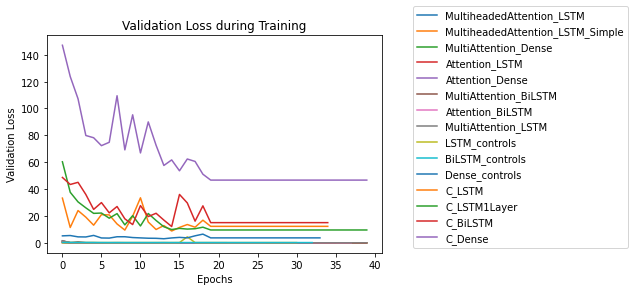

In [151]:
plt.title("Validation Loss during Training")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
for data in model_data:
    # (loss, acc, mape, train_time, eval_time, hist, model.name)
    plt.plot(data[-2].history['val_loss'], label=data[-1])
plt.legend(loc='lower right', bbox_to_anchor=(1.75,0))

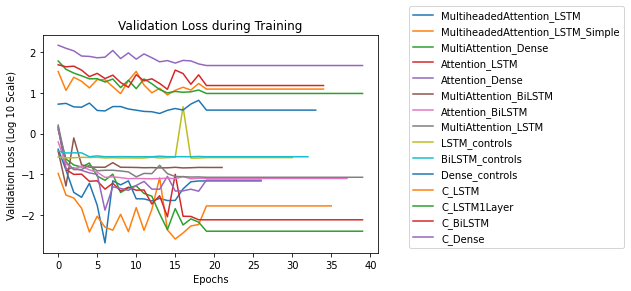

In [152]:
plt.title("Validation Loss during Training")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss (Log 10 Scale)")
for data in model_data:
    # (loss, acc, mape, train_time, eval_time, hist, model.name)
    plt.plot(np.log10(data[-2].history['val_loss']), label=data[-1])
plt.legend(loc='lower right', bbox_to_anchor=(1.75,0))

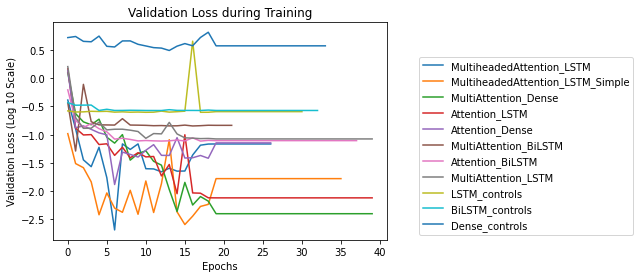

In [153]:
plt.title("Validation Loss during Training")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss (Log 10 Scale)")
for data in model_data:
    # (loss, acc, mape, train_time, eval_time, hist, model.name)
    if data[-1][0] != "C":
        plt.plot(np.log10(data[-2].history['val_loss']), label=data[-1])
plt.legend(loc='lower right', bbox_to_anchor=(1.75,0))

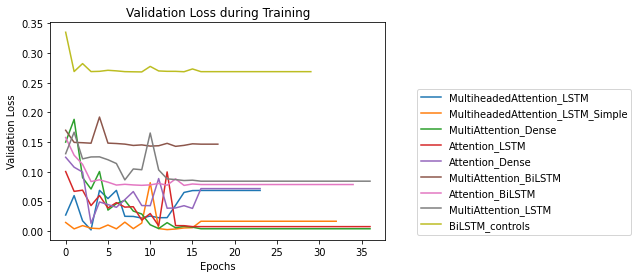

In [148]:
plt.title("Validation Loss during Training")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
for data in model_data:
    # (loss, acc, mape, train_time, eval_time, hist, model.name)
    if data[-1][0] in ["M", "A", "B"]:
        plt.plot(data[-2].history['val_loss'][3:], label=data[-1])
plt.legend(loc='lower right', bbox_to_anchor=(1.75,0))

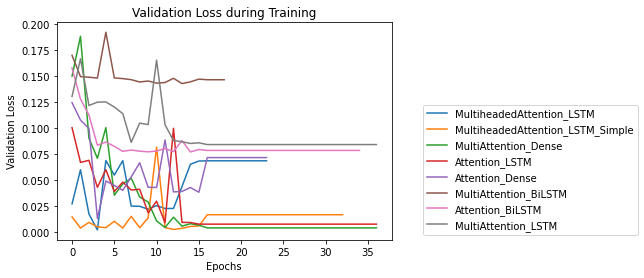

In [149]:
plt.title("Validation Loss during Training")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
for data in model_data:
    # (loss, acc, mape, train_time, eval_time, hist, model.name)
    if data[-1][0] in ["M", "A"]:
        plt.plot(data[-2].history['val_loss'][3:], label=data[-1])
plt.legend(loc='lower right', bbox_to_anchor=(1.75,0))

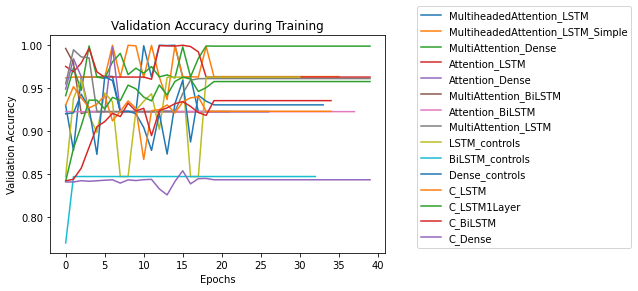

In [150]:
plt.title("Validation Accuracy during Training")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
for data in model_data:
    # (loss, acc, mape, train_time, eval_time, hist, model.name)
    plt.plot(data[-2].history['val_accuracy'], label=data[-1])
plt.legend(loc='lower right', bbox_to_anchor=(1.75,0))

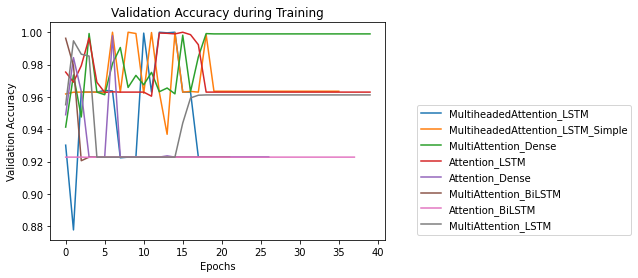

In [154]:
plt.title("Validation Accuracy during Training")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
for data in model_data:
    # (loss, acc, mape, train_time, eval_time, hist, model.name)
    if data[-1][0] in ['A', 'M']:
        plt.plot(data[-2].history['val_accuracy'], label=data[-1])
plt.legend(loc='lower right', bbox_to_anchor=(1.75,0))

In [122]:
# Plot Test Loss
test_losses = {}

# Plot Test Accuracy
test_acc = {}

# (loss, acc, mape, train_time, eval_time, hist, model.name)
for data in model_data:
    test_losses[data[-1]] = data[0]
    test_acc[data[-1]] = data[1]

<ipython-input-123-590da7168d18>:21: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


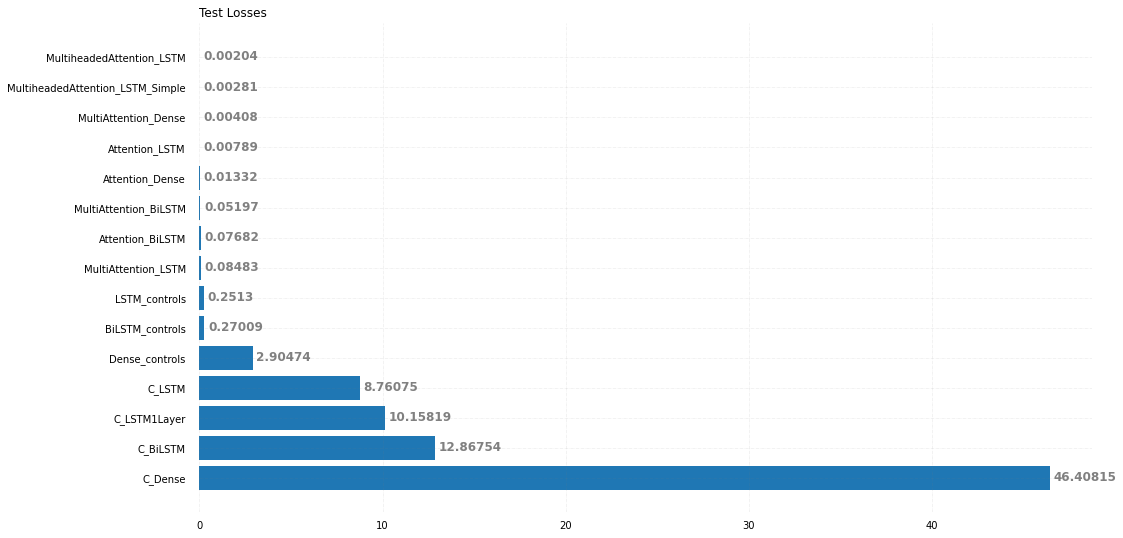

In [123]:
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(list(test_losses.keys()),
       list(test_losses.values()))
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 5)),
             fontsize = 12, fontweight ='bold',
             color ='grey')

ax.set_title("Test Losses",
         loc ='left', )
plt.show()

<ipython-input-124-461eaf823cb9>:21: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


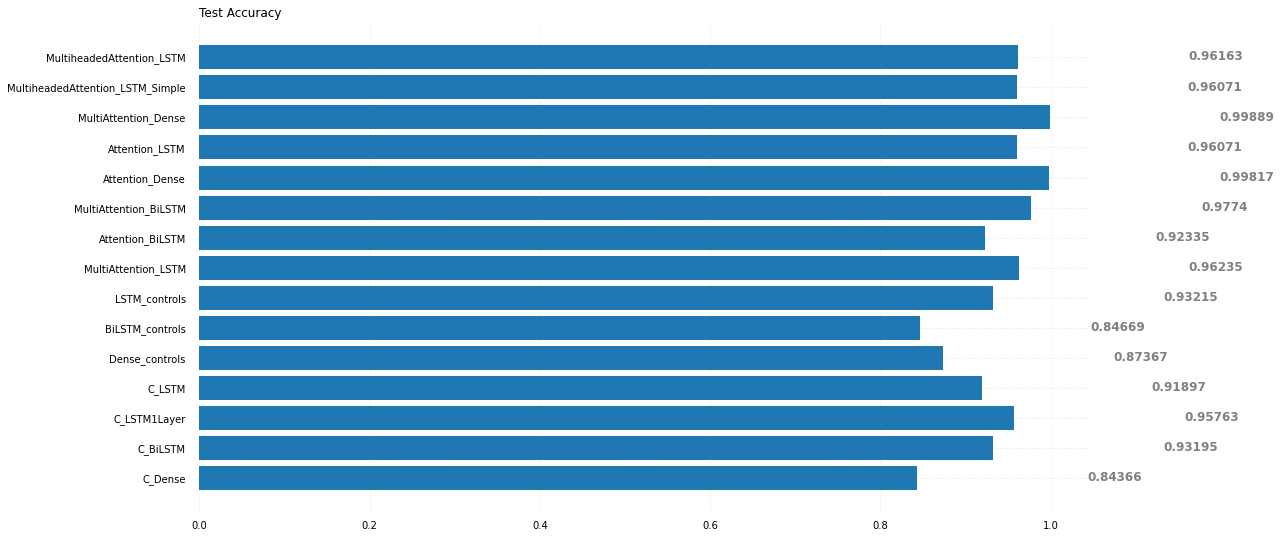

In [124]:
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(list(test_acc.keys()),
       list(test_acc.values()))
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 5)),
             fontsize = 12, fontweight ='bold',
             color ='grey')

ax.set_title("Test Accuracy",
         loc ='left', )
plt.show()

# Saving Data

In [100]:
import pickle

In [155]:
# (loss, acc, mape, train_time, eval_time, hist, model.name)
for data in model_data:
    name = data[-1]
    if name[0] not in ['M', "A", "C"]:
        name = f'B_{name}'
    h = data[-2].history
    with open('Trained_Models/{}.pkl'.format(name), 'wb') as f:
        # (loss, acc, mape, train_time, eval_time, hist, model.name)
        pickle.dump([data[0], data[1], data[2], data[3], data[4], h, name], f)

In [156]:
os.listdir('./Trained_Models')

['.ipynb_checkpoints',
 'MultiAttention_Dense.pkl',
 'MultiheadedAttention_LSTM_Simple.pkl',
 'Attention_BiLSTM.pkl',
 'B_Dense_controls.pkl',
 'Attention_LSTM.pkl',
 'B_LSTM_controls.pkl',
 'B_BiLSTM_controls.pkl',
 'MultiheadedAttention_LSTM.pkl',
 'C_LSTM.pkl',
 'C_LSTM1Layer.pkl',
 'Attention_Dense.pkl',
 'MultiAttention_BiLSTM.pkl',
 'MultiAttention_LSTM.pkl',
 'C_Dense.pkl',
 'C_BiLSTM.pkl']

In [ ]:
'''
A: Attention Models
B: Models without Attention, Input has both States and Controls
C: Models without Attention, Input has only States
'''